# Assignment 2: Voting Visualized

## Deadline

Oct. 24th

## Important notes

- Make sure you push on GitHub your notebook with all the cells already evaluated.
- Note that maps do not render in a standard Github environment. You should export them to HTML and link them in your notebook.
- Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you implemented.
- Please write all your comments in English, and use meaningful variable names in your code.
- Your repo should have a single notebook (plus the data files necessary) in the master branch. If there are multiple notebooks present, we will not grade anything. 

## Background


* __Are you curious to know what the political leanings of the people of Switzerland are?__
* __Do you wake up in a cold sweat, wondering which party won the last cantonal parliament election in Vaud?__
* __Are you looking to learn all sorts of visualizations, including maps, in Python?__

__If your answer to any of the above is yes, this assignment is just right for you. Otherwise, it's still an assignment, so we're terribly sorry.__

__The chief aim of this assignment is to familiarize you with visualizations in Python, particularly maps, and also to give you some insight into how visualizations are to be interpreted. The data we will use is the data on Swiss cantonal parliament elections from 2007 to 2018, which contains, for each cantonal election in this time period, the voting percentages for each party and canton.__

__For the visualization part, install [Folium](Folium) (_Hint: it is not available in your standard Anaconda environment, therefore search on the Web how to install it easily!_). Folium's README comes with very clear examples, and links to their own iPython Notebooks -- make good use of this information. For your own convenience, in this same directory you can already find one TopoJSON file, containing the geo-coordinates of the cantonal borders of Switzerland.__

__One last, general reminder: back up any hypotheses and claims with data, since this is an important aspect of the course.__

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import folium
import zipfile
import math
from datetime import date, time, datetime

import re

pd.options.mode.chained_assignment = None
# default='warn', Mutes warnings when copying a slice from a DataFrame
%load_ext autoreload
%autoreload 2

In [2]:
data_folder = './data/'

## Task 1: Cartography and census

__A) Display a Swiss map that has cantonal borders as well as the national borders. We provide a TopoJSON `data/ch-cantons.topojson.json` that contains the borders of the cantons.__

__B) Take the spreadsheet `data/communes_pop.xls`, collected from [admin.ch](https://www.bfs.admin.ch/bfs/fr/home/statistiques/catalogues-banques-donnees/tableaux.assetdetail.5886191.html), containing population figures for every commune. You can use [pd.read_excel()](https://pandas.pydata.org/pandas-docs/version/0.20/generated/pandas.read_excel.html) to read the file and to select specific sheets. Plot a histogram of the population counts and explain your observations. Do not use a log-scale plot for now. What does this histogram tell you about urban and rural communes in Switzerland? Are there any clear outliers on either side, and if so, which communes?__

__C) The figure below represents 4 types of histogram. At this stage, our distribution should look like Fig.(a). A common way to represent [power-laws](https://en.wikipedia.org/wiki/Power_law) is to use a histogram using a log-log scale  -- remember: the x-axis of an histogram is segmented in bins of equal sizes and y-values are the counts of each bin. As shown in Fig.(b), small bins sizes might introduce artifacts. Fig.(b) and Fig.(c) are examples of histograms with two different bin sizes. Another great way to visualize such distribution is to use a cumulative representation, as show in Fig.(d), in which the y-axis represents the number of data points with values greater than y.__
  
__Create the figures (b) and (d) using the data extracted for task 1B. For Fig.(b), represent two histograms using two different bin sizes and provide a brief description of the results. What does this tell you about the relationship between the two variables, namely the frequency of each bin and the value (i.e. population in case of the communal data) for each bin?__

<img src="plaw_crop.png" style="width: 600px;">
  
__The figure is extracted from [this paper](https://arxiv.org/pdf/cond-mat/0412004.pdf) that contains more information about this family of distributions.__

---
## 1A. A Map of Switzerland

__Display a Swiss map that has cantonal borders as well as the national borders. We provide a TopoJSON `data/ch-cantons.topojson.json` that contains the borders of the cantons.__

We use folium to create a map centered at Switzerland, displaying the cantonal and national borders given by our `data/ch-cantons.topojson.json` file. We also add some markers with the biggest cities for reference.

In [3]:
# create a map centered at Lausanne and add the topojson layer
swiss_map = folium.Map(
    location   = [46.7985624, 8.2319736],
    tiles      = 'openstreetmap',
    zoom_start = 8
)

# load the topojson
cantons_topojson = json.load(open(data_folder + 'ch-cantons.topojson.json'))

# add the topojson layer to the map
folium.TopoJson(
    cantons_topojson,
    'objects.cantons',
    name = 'cantons'
).add_to(swiss_map)

# add optional fancy tile styles which will appear in the top right dropdown
folium.TileLayer('Stamen Toner').add_to(swiss_map)

# add layer control (must be done after any changes to the map)
folium.LayerControl().add_to(swiss_map)

# display the map
swiss_map

# add layer control (must be done after any changes to the map)
folium.LayerControl().add_to(swiss_map)

# display the map
swiss_map

---

## 1B. Observing the Communes Vote

__Take the spreadsheet `data/communes_pop.xls`, collected from [admin.ch](https://www.bfs.admin.ch/bfs/fr/home/statistiques/catalogues-banques-donnees/tableaux.assetdetail.5886191.html), containing population figures for every commune. You can use [pd.read_excel()](https://pandas.pydata.org/pandas-docs/version/0.20/generated/pandas.read_excel.html) to read the file and to select specific sheets. Plot a histogram of the population counts and explain your observations. Do not use a log-scale plot for now. What does this histogram tell you about urban and rural communes in Switzerland? Are there any clear outliers on either side, and if so, which communes?__

#### Loading phase

We use ```read_excel()``` to only load the population data for one year (e.g. 2017) at 1st of January

In [4]:
path = data_folder + 'communes_pop.xls'
pop_2017 = pd.read_excel(path, header=5, usecols=[0,1], skipfooter=7)
pop_2017.columns = ['Population']
pop_2017.head()

,Population
Suisse 2),8419550
- Zürich,1487969
>> Bezirk Affoltern,52904
......0001 Aeugst am Albis,1977
......0002 Affoltern am Albis,11900


#### Cleaning phase

We notice that the data in the excel file is structured such that for each canton there is a summary row above all its districts with the sum of the population in all of them. The same is true for each district, subdivided into communes. Canton names start with a dash ```-```, district names start with ```>>``` and commune names start with ```......``` and an identifier. We proceed to remove the summary rows since we are only interested in the communes.

In [5]:
# first remove the top summary row for all of Switzerland
pop_2017 = pop_2017[1:]
pop_2017.head()

,Population
- Zürich,1487969
>> Bezirk Affoltern,52904
......0001 Aeugst am Albis,1977
......0002 Affoltern am Albis,11900
......0003 Bonstetten,5435


In [6]:
# extract the index column and mark undesired rows
index_df = pd.DataFrame(pop_2017.index)
index_df.columns = ['Commune']
index_df['Commune'] = index_df['Commune'].apply(lambda x: x[11:] if x[0] == '.' else np.nan)
index_df.head()

,Commune
0,NaN
1,NaN
2,Aeugst am Albis
3,Affoltern am Albis
4,Bonstetten


In [7]:
# we concatenate the clean index with the data and then drop the NaN we created. Only communes remain
comm_pop_2017 = pd.concat([pop_2017.reset_index(),index_df],axis=1)
comm_pop_2017 = comm_pop_2017.dropna(axis=0,how='any')
comm_pop_2017 = comm_pop_2017.reset_index()[['Commune','Population']]
comm_pop_2017 = comm_pop_2017.set_index('Commune').sort_values(by='Population', ascending=False)
comm_pop_2017.head()

,Population
Commune,
Zürich,402762
Genève,198979
Basel,171017
Lausanne,137810
Bern,133115


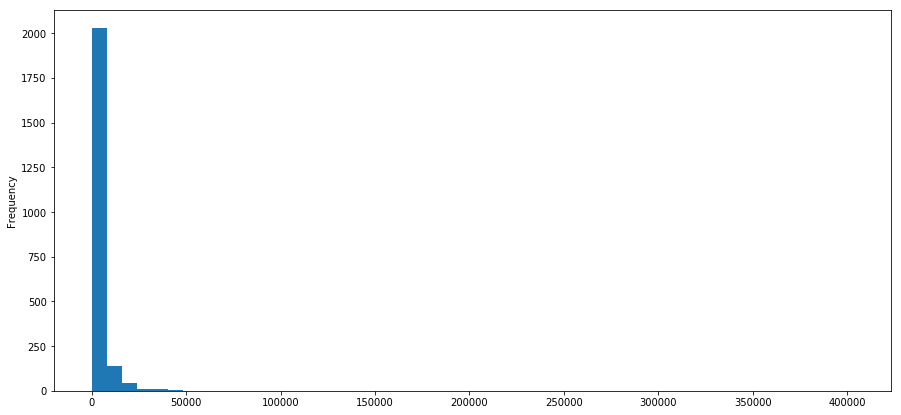

In [8]:
comm_pop_2017['Population'].plot(kind='hist', figsize=(15,7), use_index=False, bins = 50)

The histogram shows that some outliers are present since there are very few communes with more than 50000 habitants. In fact, by looking at the data we see that those correspond to the communes of the 10 biggest cities in Switzerland:

In [9]:
comm_pop_2017.head(11)

,Population
Commune,
Zürich,402762
Genève,198979
Basel,171017
Lausanne,137810
Bern,133115
Winterthur,109775
Luzern,81592
St. Gallen,75481
Lugano,63932


By taking a quick look at the stats of the table we see that indeed we have a lot of variance, probably caused by the big cities. Removing those outliers results in the variance being greatly reduced from more than 12000 to les than 5000 and furthermore removing the communes with more than 10000 inhabitants (less than 10% of the communes) drives it back to around 2000. As a reference, we note that the top 10% communes hold just above 45% of the population in Switzerland.

In [10]:
print('Stats of the dataset:\n')
print(comm_pop_2017.describe(), '\n')
print('Stats removing communes with more than 50k hab:\n')
print(comm_pop_2017[comm_pop_2017 < 50000].describe())
print('Stats removing communes with more than 10k hab:\n')
print(comm_pop_2017[comm_pop_2017 < 10000].describe(), '\n')
print('Percentage of population living in top 10% communes', comm_pop_2017[(int)(len(comm_pop_2017)/10):].sum()/comm_pop_2017.sum())

Stats of the dataset:

          Population
count    2240.000000
mean     3758.727679
std     12306.015472
min        14.000000
25%       670.500000
50%      1477.500000
75%      3604.500000
max    402762.000000 

Stats removing communes with more than 50k hab:

         Population
count   2230.000000
mean    3134.812108
std     4716.092780
min       14.000000
25%      667.500000
50%     1470.500000
75%     3568.750000
max    43568.000000
Stats removing communes with more than 10k hab:

        Population
count  2087.000000
mean   2144.782463
std    2116.758986
min      14.000000
25%     629.000000
50%    1352.000000
75%    2979.000000
max    9990.000000 

Percentage of population living in top 10% communes Population    0.4573
dtype: float64


On the other end of the spectrum, we might want to look at communes with very low population, say less than 1000 inhabitants

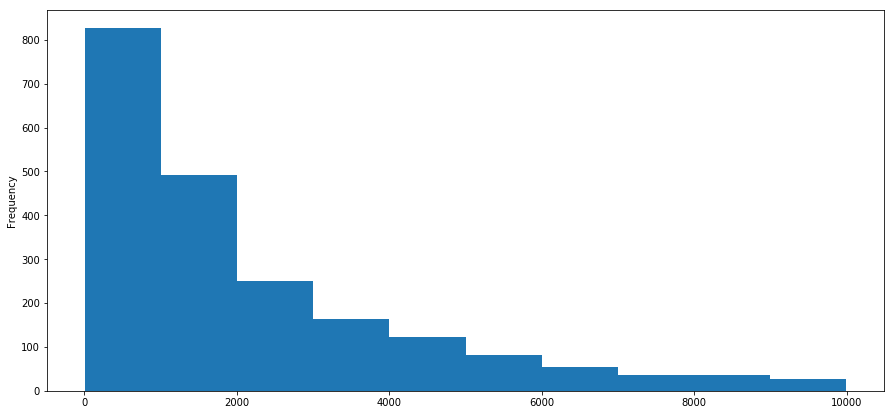

In [11]:
# Histogram of the communes with less than 10k inhabitants
comm_pop_2017['Population'][comm_pop_2017['Population'] < 10000].plot(kind='hist', figsize=(15,7), use_index=False)

We can see that there are nearly 800 communes with under 1000 habitants. All in all we can say that the population of Switzerland is fairly concentrated in the major cities and there are quite a lot of rural areas with low population.

---
## 1C. Visualizing the data

__The figure below represents 4 types of histogram. At this stage, our distribution should look like Fig.(a). A common way to represent [power-laws](https://en.wikipedia.org/wiki/Power_law) is to use a histogram using a log-log scale  -- remember: the x-axis of an histogram is segmented in bins of equal sizes and y-values are the counts of each bin. As shown in Fig.(b), small bins sizes might introduce artifacts. Fig.(b) and Fig.(c) are examples of histograms with two different bin sizes. Another great way to visualize such distribution is to use a cumulative representation, as show in Fig.(d), in which the y-axis represents the number of data points with values greater than y.__

<img src="plaw_crop.png" style="width: 600px;">

__Create the figures (b) and (d) using the data extracted for task 1B. For Fig.(b), represent two histograms using two different bin sizes and provide a brief description of the results. What does this tell you about the relationship between the two variables, namely the frequency of each bin and the value (i.e. population in case of the communal data) for each bin?__


Explain what to do and/or why

In [12]:
#Remove outliers
com_pop_without_outliers = comm_pop_2017[comm_pop_2017["Population"].apply(lambda x: x<50000 and x>100)]

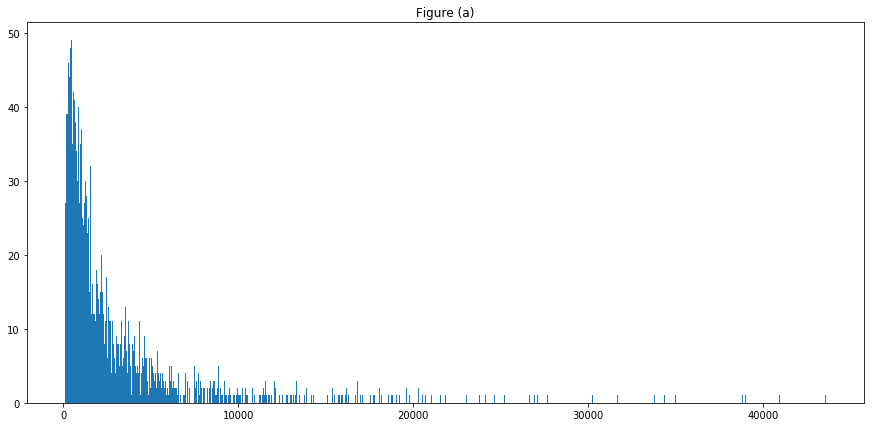

In [13]:
# numpy array with our data
pop = com_pop_without_outliers.values

fig = plt.figure(figsize=(15, 7))
ax = plt.axes()
plt.title('Figure (a)')
ax.hist(pop, bins=1000);

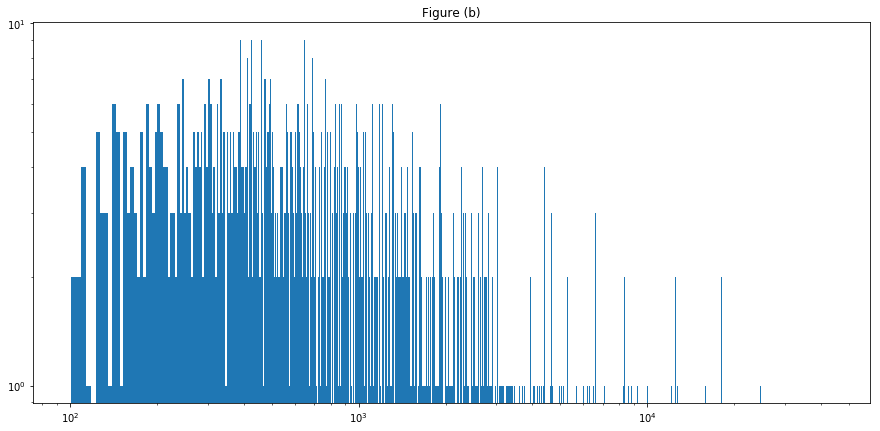

In [19]:
#hist,bins,_ = plt.hist(communes_2017_population.values, bins=1000)
# Use non-equal bin sizes, such that they look equal on log scale.
#logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
#plt.cla()
#plt.hist(communes_2017_population.values, bins=logbins)
fig = plt.figure(figsize=(15, 7))
ax = plt.axes()
plt.title('Figure (b)')
ax.set_xscale("log")
ax.set_yscale("log")
ax.hist(pop, bins=10000);

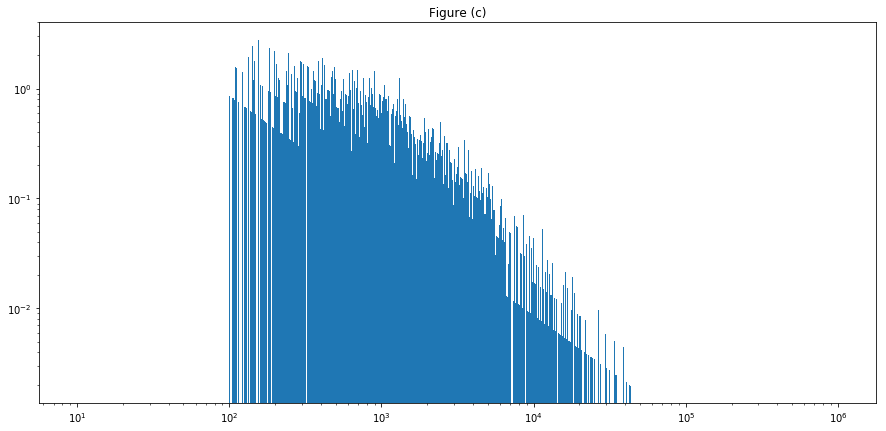

In [20]:
fig = plt.figure(figsize=(15, 7))
ax = plt.axes()
plt.title('Figure (c)')

bins = np.logspace(start=1,stop=6,num=1000,base=10)
widths = (bins[1:] - bins[:-1])
hist = np.histogram(pop, bins=bins)
hist_norm=hist[0]/widths

plt.bar(bins[:-1],hist_norm, widths)
plt.xscale('log')
plt.yscale('log')

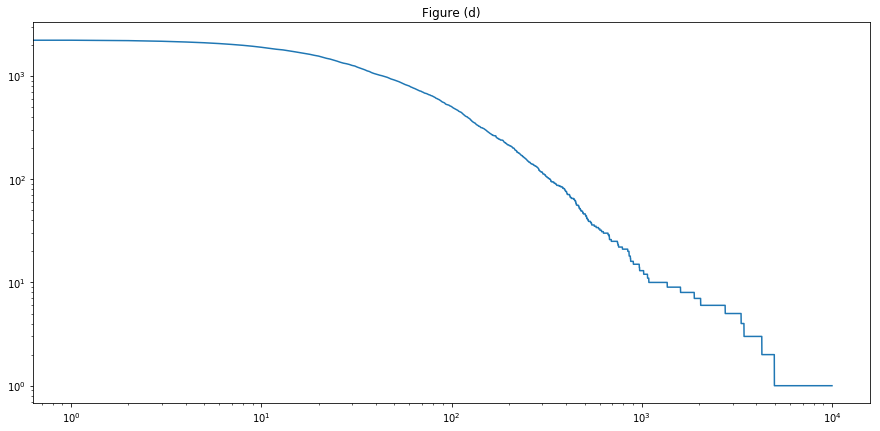

In [21]:
comm_pop_2017[comm_pop_2017 > 100].count()

counts = []

for i in np.arange(1,10000):
    counts.append(int(comm_pop_2017[comm_pop_2017 > 40*i].count()))
    
fig = plt.figure(figsize=(15, 7))
ax = plt.axes()
plt.title('Figure (d)')
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(counts);

## Task 2: Parties visualized

__We provide a spreadsheet, `data/voters.xls`, (again) collected from [admin.ch](https://www.bfs.admin.ch/bfs/fr/home/statistiques/politique/elections/conseil-national/force-partis.assetdetail.217195.html), which contains the percentage of voters for each party and for each canton. For the following task, we will focus on the period 2014-2018 (the first page of the spreadsheet). Please report any assumptions you make regarding outliers, missing values, etc. Notice that data is missing for two cantons, namely Appenzell Ausserrhoden and Graubünden, and your visualisations should include data for every other canton.__


__A) For the period 2014-2018 and for each canton, visualize, on the map, *the percentage of voters* in that canton who voted for the party [`UDC`](https://en.wikipedia.org/wiki/Swiss_People%27s_Party) (Union démocratique du centre). Does this party seem to be more popular in the German-speaking part, the French-speaking part, or the Italian-speaking part?__

__B) For the same period, now visualize *the number of residents* in each canton who voted for UDC.__

__C) Which one of the two visualizations above would be more informative in case of a national election with majority voting (i.e. when a party needs to have the largest number of citizens voting for it among all parties)? Which one is more informative for the cantonal parliament elections?__

__For part B, you can use the `data/national_council_elections.xslx` file ([guess where we got it from](https://www.bfs.admin.ch/bfs/fr/home/statistiques/politique/elections/conseil-national/participation.assetdetail.81625.html)) to have the voting-eligible population of each canton in 2015.__

---

## 2A

__For the period 2014-2018 and for each canton, visualize, on the map, *the percentage of voters* in that canton who voted for the party [`UDC`](https://en.wikipedia.org/wiki/Swiss_People%27s_Party) (Union démocratique du centre). Does this party seem to be more popular in the German-speaking part, the French-speaking part, or the Italian-speaking part?__

### Loading phase

We will first import the data from the `data/voters.xls`

In [22]:
path = data_folder + 'voters.xls'
df_orig = pd.read_excel(path)
df_orig.head()

,"Elections des parlements cantonaux, de 2014 à 2018: force des partis et attribution des listes mixtes* aux partis",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,T 17.02.05.02.03
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,Année électorale 2),Participation,PLR 6),NaN,PDC 7),NaN,PS,NaN,...,JB,NaN,Front,NaN,Grut,NaN,Autres 11),NaN,K,Total
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see, the dataframe is not formatted as expected. The `pd.read_excel()` considered every single cell as an element of the dataframe, hence the reason for all the NaN. We will then clean the dataset.

### Cleaning phase

We first read the excel file by choosing the correct sheet for 2014-2018 and choosing the the row that will be used for the column names

In [23]:
df_orig = pd.read_excel(path,sheet_name='actuel (2014-2018)', header = 3)
df_orig.head()

Année électorale 2)  Participation    PLR  6)  Unnamed: 3  \
NaN     NaN                  NaN            NaN        NaN         NaN   
        NaN                  NaN            NaN        NaN         NaN   
Zurich  NaN               2015.0      32.652497  17.327820         NaN   
Berne   NaN               2018.0      30.516313  11.717910         NaN   
Lucerne NaN               2015.0      38.741267  21.039516         NaN   

                PDC 7)  Unnamed: 5         PS  Unnamed: 7        UDC  \
NaN     NaN        NaN         NaN        NaN         NaN        NaN   
        NaN        NaN         NaN        NaN         NaN        NaN   
Zurich  NaN   4.878712         NaN  19.716444         NaN  30.023215   
Berne   NaN   0.671415         NaN  22.328775         NaN  26.760869   
Lucerne NaN  30.862513         NaN  11.848915         NaN  24.115646   

             Unnamed: 9  ...    JB  Unnamed: 53  Front  Unnamed: 55  Grut  \
NaN     NaN         NaN  ...   NaN          NaN    NaN          NaN   NaN   
        NaN         NaN  ...   NaN          NaN    NaN          NaN   NaN   
Zurich  NaN         NaN  ...   NaN          NaN    NaN          NaN   NaN   
Berne   NaN         NaN  ...   NaN          NaN    NaN          NaN   NaN   
Lucerne NaN         NaN  ...   NaN          NaN    NaN          NaN   NaN   

             Unnamed: 57  Autres 11)  Unnamed: 59   K  Total  
NaN     NaN          NaN         NaN          NaN NaN    NaN  
        NaN          NaN         NaN          NaN NaN    NaN  
Zurich  NaN          NaN    0.669707          NaN NaN    100  
Berne   NaN          NaN    0.912781          NaN NaN    100  
Lucerne NaN          NaN    0.036129          NaN NaN    100  

[5 rows x 62 columns]

Let us now remove the rows and columns containing only NaN as they bring no information and are the results of empty cells in the `data/voters.xls` file

In [24]:
df_orig = df_orig.reset_index().dropna(axis = 'columns', how='all')
df_orig = df_orig.dropna(axis = 'rows', how = 'all')
df_orig.head()

,level_0,Année électorale 2),Participation,PLR 6),PDC 7),PS,UDC,PLS 6),PEV,PCS,...,PSA,PES,AVF 8),Sol.,DS,UDF,Lega,MCR,Autres 11),Total
2,Zurich,2015.0,32.652497,17.327820,4.878712,19.716444,30.023215,NaN,4.271767,NaN,...,NaN,7.218776,2.977664,NaN,NaN,2.662277,NaN,NaN,0.669707,100
3,Berne,2018.0,30.516313,11.717910,0.671415,22.328775,26.760869,NaN,6.172897,NaN,...,0.681873,10.104467,0.495841,NaN,0.179432,3.710624,NaN,NaN,0.912781,100
4,Lucerne,2015.0,38.741267,21.039516,30.862513,11.848915,24.115646,NaN,0.199143,NaN,...,NaN,6.700011,NaN,NaN,NaN,NaN,NaN,NaN,0.036129,100
5,Uri 1),2016.0,61.989056,26.856698,31.298814,12.984966,24.053191,NaN,NaN,NaN,...,NaN,2.378061,NaN,NaN,NaN,NaN,NaN,NaN,2.428270,100
6,Schwytz,2016.0,37.747088,21.628996,27.167707,12.925363,33.115090,NaN,0.304428,NaN,...,NaN,0.800215,NaN,NaN,NaN,NaN,NaN,NaN,1.513578,100


Now let us set the canton names as the index for this dataframe

In [25]:
df_orig['Cantons'] = df_orig['level_0']
df_orig = df_orig.drop('level_0',axis=1)
df_orig = df_orig.set_index('Cantons')
df_orig.head()

,Année électorale 2),Participation,PLR 6),PDC 7),PS,UDC,PLS 6),PEV,PCS,PVL,...,PSA,PES,AVF 8),Sol.,DS,UDF,Lega,MCR,Autres 11),Total
Cantons,,,,,,,,,,,,,,,,,,,,,
Zurich,2015.0,32.652497,17.327820,4.878712,19.716444,30.023215,NaN,4.271767,NaN,7.637858,...,NaN,7.218776,2.977664,NaN,NaN,2.662277,NaN,NaN,0.669707,100
Berne,2018.0,30.516313,11.717910,0.671415,22.328775,26.760869,NaN,6.172897,NaN,6.914731,...,0.681873,10.104467,0.495841,NaN,0.179432,3.710624,NaN,NaN,0.912781,100
Lucerne,2015.0,38.741267,21.039516,30.862513,11.848915,24.115646,NaN,0.199143,NaN,4.320211,...,NaN,6.700011,NaN,NaN,NaN,NaN,NaN,NaN,0.036129,100
Uri 1),2016.0,61.989056,26.856698,31.298814,12.984966,24.053191,NaN,NaN,NaN,NaN,...,NaN,2.378061,NaN,NaN,NaN,NaN,NaN,NaN,2.428270,100
Schwytz,2016.0,37.747088,21.628996,27.167707,12.925363,33.115090,NaN,0.304428,NaN,2.544623,...,NaN,0.800215,NaN,NaN,NaN,NaN,NaN,NaN,1.513578,100


The head of the dataframe looks correct (except for the NaN's which will be solved later). Now let us check the tail.

In [26]:
df_orig.tail()

,Année électorale 2),Participation,PLR 6),PDC 7),PS,UDC,PLS 6),PEV,PCS,PVL,...,PSA,PES,AVF 8),Sol.,DS,UDF,Lega,MCR,Autres 11),Total
Cantons,,,,,,,,,,,,,,,,,,,,,
Office fédéral de la statistique: statistique des élections cantonales; Centre d'études sur la démocratie Aarau (ZDA).,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dernière modification: 02.07.2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Renseignements:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Section Politique, Culture, Médias, poku@bfs.admin.ch, 058 463 61 58.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
© OFS – Encyclopédie statistique de la Suisse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see the last cells are the annotations present in the `data/voters.xls` file. Since we do not need them we can just ignore them. Since we also know that there are 26 cantons in switzerland, we can just take the first 26 rows of the dataframe.

In [27]:
df_orig = df_orig[:26]
df_orig.head()

,Année électorale 2),Participation,PLR 6),PDC 7),PS,UDC,PLS 6),PEV,PCS,PVL,...,PSA,PES,AVF 8),Sol.,DS,UDF,Lega,MCR,Autres 11),Total
Cantons,,,,,,,,,,,,,,,,,,,,,
Zurich,2015.0,32.652497,17.327820,4.878712,19.716444,30.023215,NaN,4.271767,NaN,7.637858,...,NaN,7.218776,2.977664,NaN,NaN,2.662277,NaN,NaN,0.669707,100
Berne,2018.0,30.516313,11.717910,0.671415,22.328775,26.760869,NaN,6.172897,NaN,6.914731,...,0.681873,10.104467,0.495841,NaN,0.179432,3.710624,NaN,NaN,0.912781,100
Lucerne,2015.0,38.741267,21.039516,30.862513,11.848915,24.115646,NaN,0.199143,NaN,4.320211,...,NaN,6.700011,NaN,NaN,NaN,NaN,NaN,NaN,0.036129,100
Uri 1),2016.0,61.989056,26.856698,31.298814,12.984966,24.053191,NaN,NaN,NaN,NaN,...,NaN,2.378061,NaN,NaN,NaN,NaN,NaN,NaN,2.428270,100
Schwytz,2016.0,37.747088,21.628996,27.167707,12.925363,33.115090,NaN,0.304428,NaN,2.544623,...,NaN,0.800215,NaN,NaN,NaN,NaN,NaN,NaN,1.513578,100


Let us now take care of all the NaN. Since every NaN represents 0% (can be checked, since summing the % vote for each canton, excluding NaN, results in 100) we will replace each NaN with 0

In [28]:
df_orig = df_orig.fillna(value=0)
df_orig.head()

,Année électorale 2),Participation,PLR 6),PDC 7),PS,UDC,PLS 6),PEV,PCS,PVL,...,PSA,PES,AVF 8),Sol.,DS,UDF,Lega,MCR,Autres 11),Total
Cantons,,,,,,,,,,,,,,,,,,,,,
Zurich,2015.0,32.652497,17.327820,4.878712,19.716444,30.023215,0.0,4.271767,0.0,7.637858,...,0.000000,7.218776,2.977664,0.0,0.000000,2.662277,0.0,0.0,0.669707,100
Berne,2018.0,30.516313,11.717910,0.671415,22.328775,26.760869,0.0,6.172897,0.0,6.914731,...,0.681873,10.104467,0.495841,0.0,0.179432,3.710624,0.0,0.0,0.912781,100
Lucerne,2015.0,38.741267,21.039516,30.862513,11.848915,24.115646,0.0,0.199143,0.0,4.320211,...,0.000000,6.700011,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.036129,100
Uri 1),2016.0,61.989056,26.856698,31.298814,12.984966,24.053191,0.0,0.000000,0.0,0.000000,...,0.000000,2.378061,0.000000,0.0,0.000000,0.000000,0.0,0.0,2.428270,100
Schwytz,2016.0,37.747088,21.628996,27.167707,12.925363,33.115090,0.0,0.304428,0.0,2.544623,...,0.000000,0.800215,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.513578,100


Now we have two values missing, namely for the totals of the following two cantons: Grisons and Appenzell Rh In.

Grisons: Since there are no votes for Grisons (participation = 0), we can set the total to 0.


Appenzell Rh In: The participation 36.111, but 0 for every political party (can be checked by getting the list of unique values for the Grison canton). We can notice that the participation for both Appenzell's is the same, which would imply that for calculation puropses both cantons are considered as one at least in terms of the participation rate. To correct this, we will leave both Appenzell (otherwise nightmare when combining with the topojson file later) and just set the total for Appenzell Rh In to 0 since according to the data the vote rate for every political party stil remains 0.

In [29]:
df_orig.loc['Grisons 5)','Total':'Total'] = [0]
df_orig.loc['Appenzell Rh. Int. 4) 5)','Total':'Total'] = [0]
df_orig.head()

,Année électorale 2),Participation,PLR 6),PDC 7),PS,UDC,PLS 6),PEV,PCS,PVL,...,PSA,PES,AVF 8),Sol.,DS,UDF,Lega,MCR,Autres 11),Total
Cantons,,,,,,,,,,,,,,,,,,,,,
Zurich,2015.0,32.652497,17.327820,4.878712,19.716444,30.023215,0.0,4.271767,0.0,7.637858,...,0.000000,7.218776,2.977664,0.0,0.000000,2.662277,0.0,0.0,0.669707,100
Berne,2018.0,30.516313,11.717910,0.671415,22.328775,26.760869,0.0,6.172897,0.0,6.914731,...,0.681873,10.104467,0.495841,0.0,0.179432,3.710624,0.0,0.0,0.912781,100
Lucerne,2015.0,38.741267,21.039516,30.862513,11.848915,24.115646,0.0,0.199143,0.0,4.320211,...,0.000000,6.700011,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.036129,100
Uri 1),2016.0,61.989056,26.856698,31.298814,12.984966,24.053191,0.0,0.000000,0.0,0.000000,...,0.000000,2.378061,0.000000,0.0,0.000000,0.000000,0.0,0.0,2.428270,100
Schwytz,2016.0,37.747088,21.628996,27.167707,12.925363,33.115090,0.0,0.304428,0.0,2.544623,...,0.000000,0.800215,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.513578,100


Now let us remove the extra bit of unecessary information in the indexes (cantons) such as 5) in 'Grisons 5)'

In [30]:
df_orig = df_orig.reset_index()
df_orig['Cantons'] = df_orig['Cantons'].apply(lambda x: re.sub('[0-9][)]','',x))
df_orig['Cantons'] = df_orig['Cantons'].apply(lambda x: re.sub('[0-9]','',x))
df_orig.head()

,Cantons,Année électorale 2),Participation,PLR 6),PDC 7),PS,UDC,PLS 6),PEV,PCS,...,PSA,PES,AVF 8),Sol.,DS,UDF,Lega,MCR,Autres 11),Total
0,Zurich,2015.0,32.652497,17.327820,4.878712,19.716444,30.023215,0.0,4.271767,0.0,...,0.000000,7.218776,2.977664,0.0,0.000000,2.662277,0.0,0.0,0.669707,100
1,Berne,2018.0,30.516313,11.717910,0.671415,22.328775,26.760869,0.0,6.172897,0.0,...,0.681873,10.104467,0.495841,0.0,0.179432,3.710624,0.0,0.0,0.912781,100
2,Lucerne,2015.0,38.741267,21.039516,30.862513,11.848915,24.115646,0.0,0.199143,0.0,...,0.000000,6.700011,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.036129,100
3,Uri,2016.0,61.989056,26.856698,31.298814,12.984966,24.053191,0.0,0.000000,0.0,...,0.000000,2.378061,0.000000,0.0,0.000000,0.000000,0.0,0.0,2.428270,100
4,Schwytz,2016.0,37.747088,21.628996,27.167707,12.925363,33.115090,0.0,0.304428,0.0,...,0.000000,0.800215,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.513578,100


### Formatting

We will now prepare the dataset that we will use for our vizualization. 

First we only need the UDC column from the dataframe `df_orig`.

In [31]:
df_udc = df_orig.copy()[['Cantons','UDC']]
df_udc.head()

,Cantons,UDC
0,Zurich,30.023215
1,Berne,26.760869
2,Lucerne,24.115646
3,Uri,24.053191
4,Schwytz,33.115090


### Visualization

Ideally for our vizualization, we would like a choropleth map and a marker on each canton which would show the the vote rate for that canton. 

MARKERS:

First for the markers, we need the gps (latitude and longitude) coordinates for each cantons. For that we can use the geopy library as such (install library as such: pip install geopy):

WARNING: sometimes geopy will generate a runtime error (server busy), in that case just rerun the cell and it hould work

In [32]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")

df_udc['Coord'] = df_udc['Cantons'].apply(lambda x: geolocator.geocode(x))
df_udc['Coord'] = df_udc['Coord'].apply(lambda x: tuple(x.point) if x else None)
df_udc['Coord_x'] = df_udc['Coord'].apply(lambda x: x[0] if x else None)
df_udc['Coord_y'] = df_udc['Coord'].apply(lambda x: x[1] if x else None)
df_udc = df_udc[['Cantons','UDC','Coord_x','Coord_y']]
df_udc.head()

,Cantons,UDC,Coord_x,Coord_y
0,Zurich,30.023215,47.376943,8.541406
1,Berne,26.760869,46.948271,7.451451
2,Lucerne,24.115646,47.050545,8.305468
3,Uri,24.053191,46.786441,8.642016
4,Schwytz,33.115090,47.021185,8.653560


The geocoder did not manage to find the coordinates of both Appenzell's. Hence we will add them by hand (found on openstreetmap.org).

In [33]:
df_udc.loc[14,'Coord_x':'Coord_y'] = [47.3595595, 9.4805951]
df_udc.loc[15,'Coord_x':'Coord_y'] = [47.3285447, 9.4095367]
df_udc.head(16)

,Cantons,UDC,Coord_x,Coord_y
0,Zurich,30.023215,47.376943,8.541406
1,Berne,26.760869,46.948271,7.451451
2,Lucerne,24.115646,47.050545,8.305468
3,Uri,24.053191,46.786441,8.642016
4,Schwytz,33.115090,47.021185,8.653560
5,Obwald,24.532303,46.861386,8.206782
6,Nidwald,25.916631,46.895621,8.404138
7,Glaris,25.275361,47.042212,9.067404
8,Zoug,23.631802,47.167990,8.517365
9,Fribourg,19.717606,46.678912,7.102711


Let us now place a marker for each canton just to check that they are all inside switzerland

In [34]:
marker_check_map = folium.Map(
    location   = [46.7985624, 8.2319736],
    tiles      = 'openstreetmap',
    zoom_start = 8
)

# load the topojson
#cantons_topojson = json.load(open(data_folder + 'ch-cantons.topojson.json'))


for i in range(26):
    coord_x = df_udc.iloc[i]['Coord_x']
    coord_y = df_udc.iloc[i]['Coord_y']
    canton_name = df_udc.iloc[i]['Cantons']
    udc_rate = df_udc.iloc[i]['UDC']
    
    folium.Marker(
        location = [coord_x, coord_y],
        popup    = canton_name + ' UDC: ' + str(udc_rate) + '%',
        icon     = folium.Icon(icon='info-sign')
    ).add_to(marker_check_map)
    
marker_check_map

As we can see the geocoder picked Jura in France, hence we shall add it manually (gps coordinates found on openstreetmap.org). Every other marker has been correctly placed

In [35]:
df_udc.loc[25,'Coord_x':'Coord_y'] = [47.3566699, 7.1598893]
df_udc.tail(5)

,Cantons,UDC,Coord_x,Coord_y
21,Vaud,15.842675,46.635696,6.532072
22,Valais,16.437539,46.230306,7.660576
23,Neuchâtel,11.489286,46.989583,6.929264
24,Genève,7.315683,46.201756,6.146601
25,Jura,11.980336,47.356670,7.159889


Let us now show our 50% completed vizualization (Next step is choropleth)

In [36]:
udc_map = folium.Map(
    location   = [46.8985624, 8.2319736],
    tiles      = 'openstreetmap',
    zoom_start = 8
)

# load the topojson
#cantons_topojson = json.load(open(data_folder + 'ch-cantons.topojson.json'))


for i in range(26):
    coord_x = df_udc.iloc[i]['Coord_x']
    coord_y = df_udc.iloc[i]['Coord_y']
    canton_name = df_udc.iloc[i]['Cantons']
    udc_rate = df_udc.iloc[i]['UDC']
    
    folium.Marker(
        location = [coord_x, coord_y],
        popup    = canton_name + ' UDC: ' + str(udc_rate) + '%',
        icon     = folium.Icon(icon='info-sign')
    ).add_to(udc_map)
    
udc_map

### Choropleth

We shall now complete our vizualization by adding a choropleth.

Let us first load the `topojson` file

In [37]:
cantons_topojson = json.load(open(data_folder + 'ch-cantons.topojson.json'))

To use the `foluium.choropleth` method the id's in the json file and a column in our dataframe must match. Hence let us extract the id's from the json file and concatenante them to our dataframe.

In [38]:
ca = cantons_topojson['objects']['cantons']['geometries']
cantons_ids = []
for c in ca:
    cantons_ids.append(c['id'])

df_udc['Cantons_json'] = cantons_ids
df_udc.head()

,Cantons,UDC,Coord_x,Coord_y,Cantons_json
0,Zurich,30.023215,47.376943,8.541406,ZH
1,Berne,26.760869,46.948271,7.451451,BE
2,Lucerne,24.115646,47.050545,8.305468,LU
3,Uri,24.053191,46.786441,8.642016,UR
4,Schwytz,33.115090,47.021185,8.653560,SZ


Finally we can add the final touch to our vizualization.

In [39]:
udc_map.choropleth(
    
    geo_data=cantons_topojson,
    name='choropleth_rate',
    data=df_udc,
    columns=['Cantons_json','UDC'],
    key_on='feature.id',
    topojson = 'objects.cantons',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Rate of UDC voters (%)')

udc_map

C:\Users\jorge\AppData\Local\Continuum\anaconda3\lib\site-packages\folium\folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


We can see that the UDC party is more (if not most) popular from North East(Zurich, Thurgovie, ...) of Switzerland to the center (Berne, Luzerne,...), which represents the german speaking part of switzerland. The % of UDC voters is over 33%. There is an exception for both Appenzell's which are the two smallest cantons in Switzerland.

---
## 2B

__For the same period, now visualize *the number of residents* in each canton who voted for UDC.__

### Loading phase

Let us first import the data from `data/national_council_elections.xlsx`. The rest of the necessary data can be found in the dataframes created and used in part A of task 2.

In [40]:
df_residents = pd.read_excel(data_folder+ 'national_council_elections.xlsx')
df_residents.head()

,Elections au Conseil national de 2015:,Unnamed: 1,Unnamed: 2,T 17.02.02.04.01
0,"électeurs inscrits, électeurs, participation a...",NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,Electeurs inscrits,Electeurs 2),Participation en %
4,NaN,NaN,NaN,NaN


### Cleaning phase

In [41]:
df_residents = pd.read_excel(data_folder + 'national_council_elections.xlsx', header=4, usecols=[0,1,2,3], skiprows=4, skipfooter=10)
df_residents.columns = ['Cantons','Electeurs inscrit','Electeurs participant','Participation %']
df_residents.head()

,Cantons,Electeurs inscrit,Electeurs participant,Participation %
0,Zurich,907623,428837,47.248362
1,Berne,729203,357770,49.063155
2,Lucerne,271143,138096,50.931059
3,Uri 1),26414,15091,57.132581
4,Schwytz,102145,54857,53.705027


Same as before let us remove the unecessary bits of dat for each cantons, mainly '1)' at the end of some Cantons such as Glaris.

In [42]:
df_residents['Cantons'] = df_residents['Cantons'].apply(lambda x: re.sub('[0-9][)]','',x))
df_residents.head()

,Cantons,Electeurs inscrit,Electeurs participant,Participation %
0,Zurich,907623,428837,47.248362
1,Berne,729203,357770,49.063155
2,Lucerne,271143,138096,50.931059
3,Uri,26414,15091,57.132581
4,Schwytz,102145,54857,53.705027


We will now sort both `df_residents` and `df_udc` by Cantons name so that we can concatenate them more easily.

In [43]:
df_residents = df_residents.sort_values(by='Cantons').reset_index()[['Cantons','Electeurs participant']]
df_residents.head()

,Cantons,Electeurs participant
0,Appenzell Rh.-Ext.,18131
1,Appenzell Rh.-Int.,4247
2,Argovie,200147
3,Berne,357770
4,Bâle-Campagne,87941


In [44]:
df_udc = df_udc.sort_values(by='Cantons').reset_index()[['Cantons','Cantons_json','Coord_x','Coord_y','UDC']]
df_udc.head()

,Cantons,Cantons_json,Coord_x,Coord_y,UDC
0,Appenzell Rh. Ext.,AR,47.359560,9.480595,16.281936
1,Appenzell Rh. Int.,AI,47.328545,9.409537,0.000000
2,Argovie,AG,47.412396,8.194832,31.937510
3,Berne,BE,46.948271,7.451451,26.760869
4,Bâle-Campagne,BL,47.509294,7.658833,26.741611


### Formatting

Let us now concatenante the columns of `df_residents` and `df_udc`. (No merge needed since both are aranged in canton's alphabetical orders).

In [45]:
df_residents = pd.concat([df_residents,df_udc[['Cantons_json','Coord_x','Coord_y','UDC']]],axis=1)
df_residents_final = df_residents.copy()
df_residents_final.head()

,Cantons,Electeurs participant,Cantons_json,Coord_x,Coord_y,UDC
0,Appenzell Rh.-Ext.,18131,AR,47.359560,9.480595,16.281936
1,Appenzell Rh.-Int.,4247,AI,47.328545,9.409537,0.000000
2,Argovie,200147,AG,47.412396,8.194832,31.937510
3,Berne,357770,BE,46.948271,7.451451,26.760869
4,Bâle-Campagne,87941,BL,47.509294,7.658833,26.741611


To obtain the popultion votes, we need to take the Electeurs participant(number of people who actually voted in the canton) multiply it by UDC (% of inhabitants in the canton that voted for UDC) and divide it by 100. Finally we round the population values.

In [46]:
df_residents_final['population votes for UDC'] = df_residents_final['Electeurs participant']*df_residents_final['UDC'] / 100
df_residents_final['population votes for UDC'] = df_residents_final['population votes for UDC'].apply(lambda x: int(x))
df_residents_final.head()

,Cantons,Electeurs participant,Cantons_json,Coord_x,Coord_y,UDC,population votes for UDC
0,Appenzell Rh.-Ext.,18131,AR,47.359560,9.480595,16.281936,2952
1,Appenzell Rh.-Int.,4247,AI,47.328545,9.409537,0.000000,0
2,Argovie,200147,AG,47.412396,8.194832,31.937510,63921
3,Berne,357770,BE,46.948271,7.451451,26.760869,95742
4,Bâle-Campagne,87941,BL,47.509294,7.658833,26.741611,23516


### Visualization

For our data vizualization, we decided to add another choropleth layer on top of the previous vizualization of Part A). We will give the user the possibility to switch between both choropleth. We shall also update the markers to also show the number of voters.

In [47]:
for i in range(26):
    coord_x = df_udc.iloc[i]['Coord_x']
    coord_y = df_udc.iloc[i]['Coord_y']
    canton_name = df_udc.iloc[i]['Cantons']
    udc_rate = df_udc.iloc[i]['UDC']
    resident = df_residents_final.iloc[i]['population votes for UDC']
    
    folium.Marker(
        location = [coord_x, coord_y],
        popup    = canton_name + ' UDC percentage: ' + str(int(udc_rate)) + '%' + '  number of voters: ' + str(resident),
        icon     = folium.Icon(icon='info-sign')
    ).add_to(udc_map)

udc_map.choropleth(
    
    geo_data=json.load(open('data/ch-cantons.topojson.json')),
    name='choropleth_population',
    data=df_residents_final,
    columns=['Cantons_json','population votes for UDC'],
    key_on='feature.id',
    topojson = 'objects.cantons',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Number of UDC voters')

folium.LayerControl().add_to(udc_map)

udc_map

---
## 2C

__Which one of the two visualizations above would be more informative in case of a national election with majority voting (i.e. when a party needs to have the largest number of citizens voting for it among all parties)? Which one is more informative for the cantonal parliament elections?__

In the case of a national election, the second vizualization (Part B, number of voters) is more important, for example the if we look at cantons such as Luzern or Schwytz, we can see that in the first choropleth (UDC %) these cantons are high on the scale (near purple color), which would indicate a high UDC voting where as in fact if we look at the number of voters (which is more important for national elections) both these cantons are pretty low on the scale. 

For the cantonal parliament, the first vizualization (Part A, perctentage of UDC voters) is more important since it represents the canton's 'opinion' for the UDC. Say over 50% of a canton votes for UDC, this tells us that the canton 'is' (at least the majority of it is) UDC. 

## Task 3: More socialism or more nationalism?

__In this section, we focus on two parties that are representative of the left and the right on the Swiss political spectrum. You will propose a way to visualize their influence over time and for each canton.__

__A) Take the two parties [`UDC`](https://en.wikipedia.org/wiki/Swiss_People%27s_Party) (Union démocratique du centre) and [`PS`](https://en.wikipedia.org/wiki/Social_Democratic_Party_of_Switzerland) (Parti socialiste suisse). For each canton, we define 'right lean' in a certain period as follows:__

$$\frac{VoteShare_{UDC} - VoteShare_{PS}}{VoteShare_{UDC} + VoteShare_{PS}}$$  

__Visualize the right lean of each canton on the map. What conclusions can you draw this time? Can you observe the [röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben) ?__

__B) For each party, devise a way to visualize the difference between its 2014-2018 vote share (i.e. percentage) and its 2010-2013 vote share for each canton. Propose a way to visualize this evolution of the party over time, and justify your choices. There's no single correct answer, but you must reasonably explain your choices.__

---
## 3A. The 'right lean'

__Visualize the right lean of each canton on the map. What conclusions can you draw this time? Can you observe the röstigraben ?__

Firstly, we compute the 'right lean' from the data set used in Task 2 (period 2014-18) and we build a new data frame with these data. Then we create a map of Switzerland (with the canton's borders) in which we can visualize the right lean of each canton and areas are shaded in proportion to the measurement of the right lean.

In [48]:
df=df_orig.copy()
df_right_lean=df[['Cantons', 'UDC', 'PS']].copy()
#Compute the right lean
df_right_lean['Right lean']= ( df['UDC'] - df['PS'] ) / ( df['UDC'] + df['PS'] )
#Replace NaN with 0
df_right_lean["Right lean"].fillna(0, inplace=True)
df_right_lean.head(3)

,Cantons,UDC,PS,Right lean
0,Zurich,30.023215,19.716444,0.207214
1,Berne,26.760869,22.328775,0.090286
2,Lucerne,24.115646,11.848915,0.341078


As in part 2, to use the `foluium.choropleth` method the id's in the json file and a column in our dataframe must match. Hence let us extract the id's from the json file and concatenante them to our dataframe.

In [49]:
ca = cantons_topojson['objects']['cantons']['geometries']
cantons_ids = []
for c in ca:
    cantons_ids.append(c['id']) 

df_right_lean['Cantons_json'] = cantons_ids

In [50]:
import os

swiss_map3 = folium.Map(
    location   = [46.8985624, 8.2319736],
    tiles      = 'openstreetmap',
    zoom_start = 8
)


for i in df['Cantons']:
    coord_x = df_udc.set_index('Cantons').loc[i]['Coord_x']
    coord_y = df_udc.set_index('Cantons').loc[i]['Coord_y']

    folium.Marker(  #We create a marker in every Canton.
        location = [coord_x, coord_y],
        popup    = i + ' right lean: ' + str("{0:.6f}".format(df_right_lean.set_index('Cantons').loc[i]['Right lean'])),
        icon     = folium.Icon(icon='info-sign', color="green")
    ).add_to(swiss_map3)

swiss_map3.choropleth(
    
    geo_data=json.load(open('data/ch-cantons.topojson.json')),
    name='choropleth',
    data=df_right_lean,
    columns=['Cantons_json','Right lean'],
    key_on='feature.id',
    topojson = 'objects.cantons',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Right lean')

folium.LayerControl().add_to(swiss_map3) 

swiss_map3

__What conclusions can you draw this time? Can you observe the röstigraben ?__


We observe that usually the more east the higher value have the 'right lean' on each canon (Reminder: Some of the cantons have 'right lean'==0 because we have no data about them). This fact agree clearly with the röstigraben occurrence. Actually, we see that the majority of the french-speaking cantons and the italian-speaking canton(Tessin) have values less than zero whereas the german-speaking cantons usually have values greater than zero.

---
## 3B. Vote share evolution

__For each party, devise a way to visualize the difference between its 2014-2018 vote share (i.e. percentage) and its 2010-2013 vote share for each canton. Propose a way to visualize this evolution of the party over time, and justify your choices. There's no single correct answer, but you must reasonably explain your choices.__

Firstly, we want to create a new data frame with the 2010-2013 data. For doing that, we need to load (and clean like in Part 2) the sheet called "2010-2013" of 'voters.xls'.

In [51]:
#We load the data from the sheet 2010-2013 and we clean as we did in part 2.
path = data_folder + 'voters.xls'
df_orig3 = pd.read_excel(path, header=2, sheet_name="2010-2013")
df_orig3 = df_orig3.drop([0,1])
df_orig3 = df_orig3.dropna(axis = 'columns', how='all')
df_orig3 = df_orig3.dropna(axis = 'rows', how = 'all')
df_orig3 = df_orig3[0:26]


df_orig3.columns = pd.Index(['Cantons']).append(df_orig3.columns[1:])
df_orig3 = df_orig3.set_index(['Cantons'])
df_orig3 = df_orig3.fillna(value=0)

df_orig3.columns = pd.Index(['Année']).append(df_orig3.columns[1:])

df3 = df_orig3.reset_index()
df3['Cantons'] = df3['Cantons'].apply(lambda x: re.sub('[0-9][)]','',x))
df3['Cantons'] = df3['Cantons'].apply(lambda x: re.sub('[0-9]','',x))

#We extract just the vote share columns
columns = ['Cantons','PLR 7)','PDC','PS','UDC','PLS 7)','PEV','PCS','PVL','PBD','PST','PSA','PES','AVF 8)','Sol.','DS','UDF','Lega','MCR','Autres 10)']
df3=df3[columns]


df3.head(3)

,Cantons,PLR 7),PDC,PS,UDC,PLS 7),PEV,PCS,PVL,PBD,PST,PSA,PES,AVF 8),Sol.,DS,UDF,Lega,MCR,Autres 10)
0,Zurich,12.934426,4.862598,19.317182,29.635552,0.0,3.778014,0.0,10.265505,3.465970,0.0,0.000000,10.569400,1.627417,0.0,0.405206,2.571601,0.0,0.0,0.567131
1,Berne,10.335474,1.256537,18.852832,26.621577,0.0,5.898273,0.0,4.071319,16.027757,0.0,1.039215,10.101410,0.000000,0.0,0.414800,4.403570,0.0,0.0,0.977237
2,Lucerne,18.864849,31.298184,10.964228,22.126508,0.0,0.000000,0.0,5.904835,1.661765,0.0,0.000000,8.668342,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.511289


We have decided to create bar charts plots with two charts for each political party to observe clearly how it have evolutioned between the two periods. For doing that we have created 2 data frames with the vote share of each party in every canton, one for 2010-13 data and one for 2014-2018 data.

In [52]:
#Reminder: df was created in part 2 and is the data frame with 2014-18 data, whereas df3 is the ones with 2010-13 data
df_2018 = df.iloc[:,3:22]  #Columns 3:22 have the vote share data
df_2018['Cantons']=df['Cantons']
df_2018.set_index("Cantons", inplace=True)

df_2013 = df3.iloc[:,0:20] 
df_2013['Cantons']=df3['Cantons']
df_2013.set_index("Cantons", inplace=True)
#We delete spaces from the canton's names in order to have the same names in both dataframes
df_2018.index = df_2018.index.str.strip()
df_2013.index = df_2013.index.str.strip()

df_2018.head(3)

,PLR 6),PDC 7),PS,UDC,PLS 6),PEV,PCS,PVL,PBD,PST 9),PSA,PES,AVF 8),Sol.,DS,UDF,Lega,MCR,Autres 11)
Cantons,,,,,,,,,,,,,,,,,,,
Zurich,17.327820,4.878712,19.716444,30.023215,0.0,4.271767,0.0,7.637858,2.615760,0.000000,0.000000,7.218776,2.977664,0.0,0.000000,2.662277,0.0,0.0,0.669707
Berne,11.717910,0.671415,22.328775,26.760869,0.0,6.172897,0.0,6.914731,9.020796,0.327589,0.681873,10.104467,0.495841,0.0,0.179432,3.710624,0.0,0.0,0.912781
Lucerne,21.039516,30.862513,11.848915,24.115646,0.0,0.199143,0.0,4.320211,0.877915,0.000000,0.000000,6.700011,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.036129


Finally, we choose one of the cantons for studying the evolution of the vote share between both period and we build the bar chart plot.

In [53]:
canton_for_visualization="Zurich"

In [54]:
#We extract the vote share data from the data frames to arrays in order to create a new data frame, df_plot.
Data2014_18 = df_2018.loc[canton_for_visualization].values
Data2010_13 = df_2013.loc[canton_for_visualization].values
index = ['Data 2014_18', 'Data 2010_13']
columns = ['PLR','PDC','PS','UDC','PLS','PEV','PCS','PVL','PBD','PST','PSA','PES','AVF','Sol.','DS','UDF','Lega','MCR','Autres']
values=[Data2014_18, Data2010_13]
#With this data frame we will obtain the bar chart automatically.
df_plot = pd.DataFrame(values, index=index)
df_plot.columns=columns
df_plot 

,PLR,PDC,PS,UDC,PLS,PEV,PCS,PVL,PBD,PST,PSA,PES,AVF,Sol.,DS,UDF,Lega,MCR,Autres
Data 2014_18,17.327820,4.878712,19.716444,30.023215,0.0,4.271767,0.0,7.637858,2.61576,0.0,0.0,7.218776,2.977664,0.0,0.000000,2.662277,0.0,0.0,0.669707
Data 2010_13,12.934426,4.862598,19.317182,29.635552,0.0,3.778014,0.0,10.265505,3.46597,0.0,0.0,10.569400,1.627417,0.0,0.405206,2.571601,0.0,0.0,0.567131


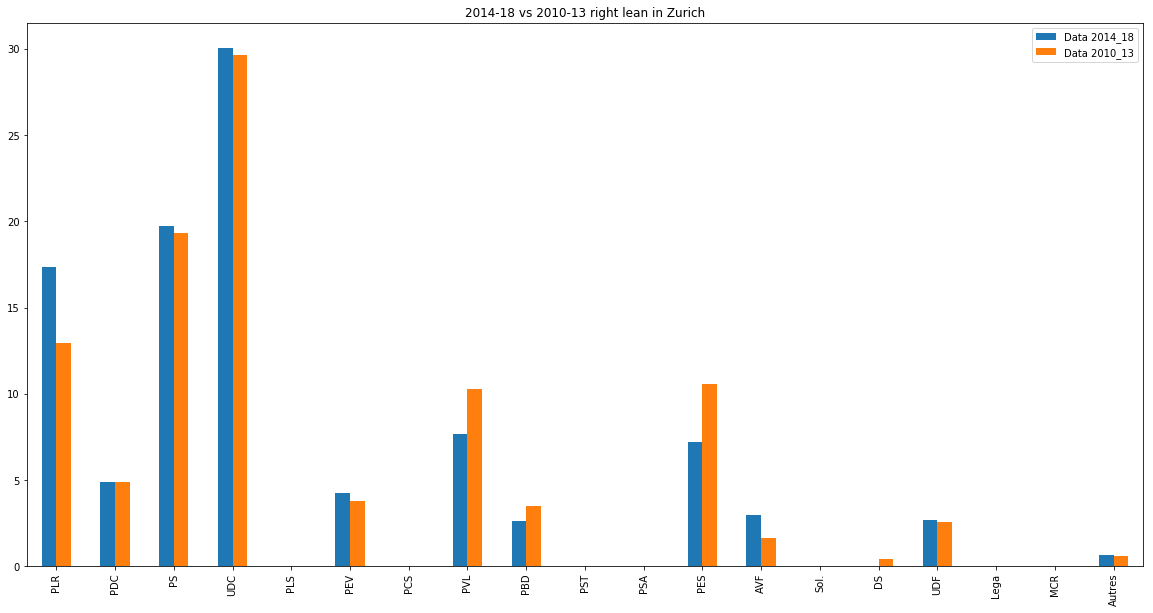

In [55]:
df_plot.T.plot.bar(figsize=(20, 10))
plt.title("2014-18 vs 2010-13 right lean in " + canton_for_visualization)
plt.show()

This seems to be one of the best ways for analizing the evolution between these periodes (2010-13 and 2014-18) of every political party in a certain canton. We can see very easily if a party have more or less votes in both periods simultaneously; this fact is why we have chosen this kind of visualization.(Just change the variable canton_for_visualization="Zurich" to the canton's name you want to see).


For example, we can clearly see that the party PLR have evoluted positively in the canton of Zurich. We also notice the appearance of a new party in this canton, we refer to DS. Finally we observe that parties like PVL, PBD and PES have evolutioned negatively.

Below you can see the bar chart for every canton.

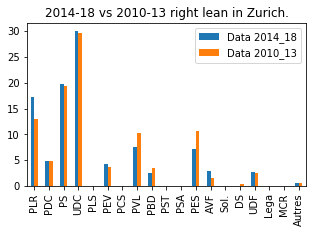

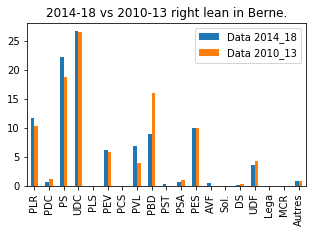

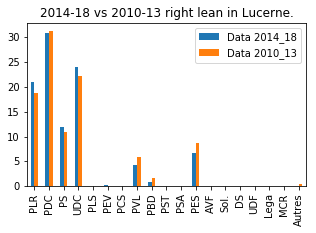

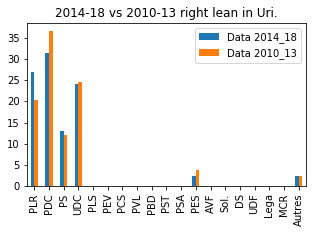

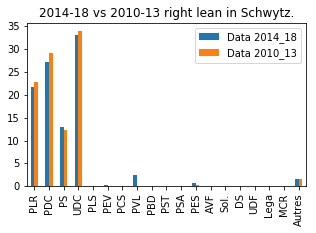

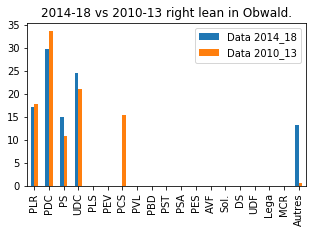

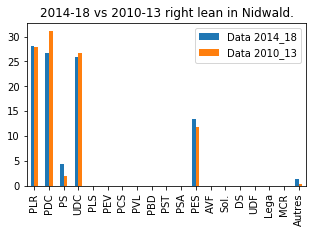

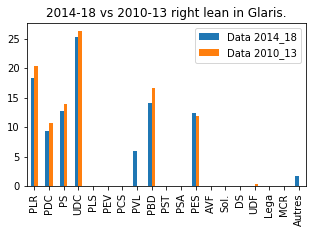

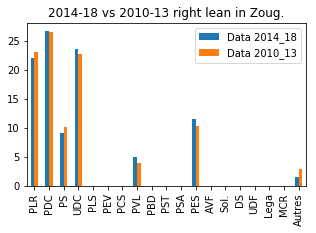

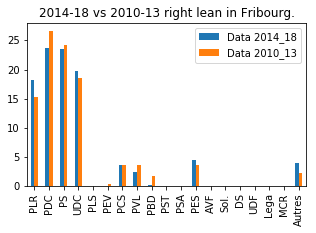

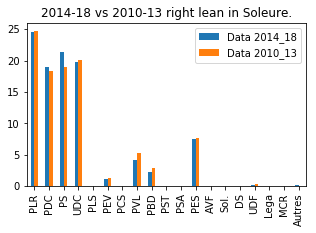

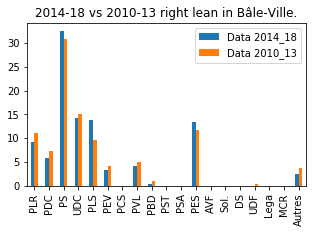

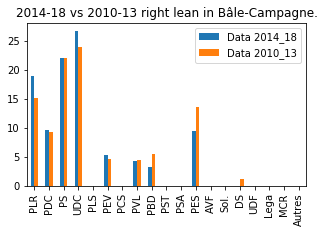

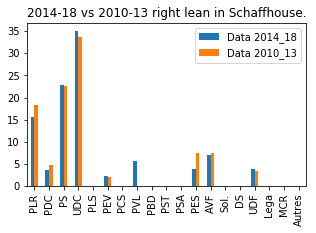

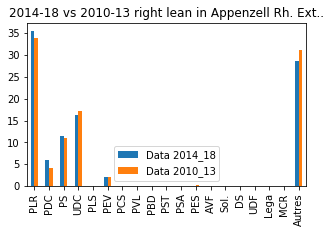

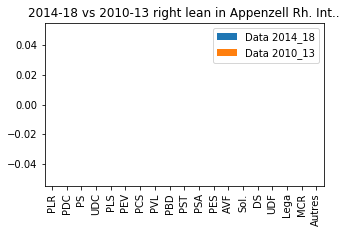

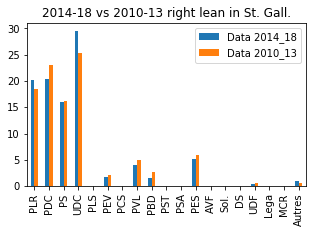

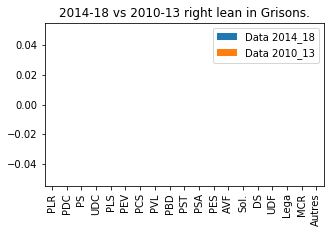

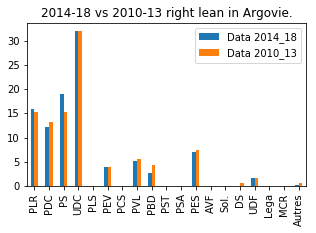

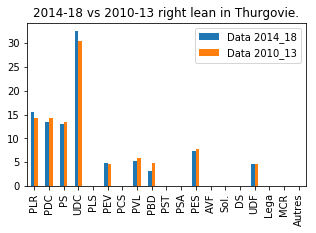

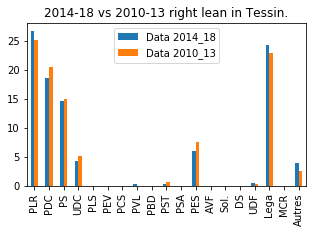

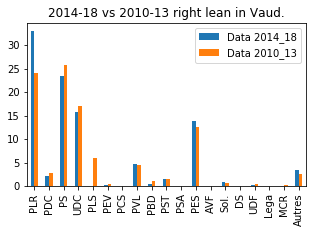

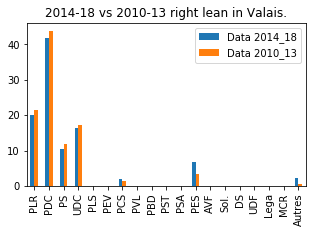

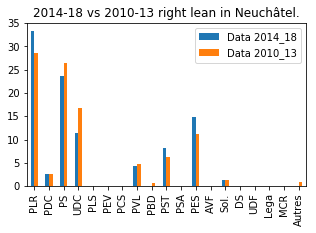

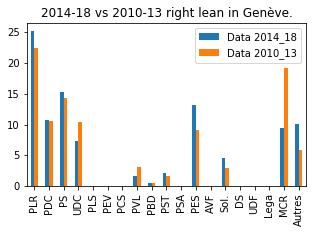

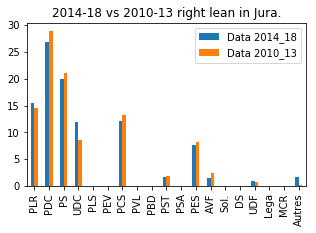

In [56]:
for canton in df_2018.index:
    Data2014_18 = df_2018.loc[canton].values
    Data2010_13 = df_2013.loc[canton].values
    values=[Data2014_18, Data2010_13]
    df_plot = pd.DataFrame(values, index=index)
    df_plot.columns=columns
    
    df_plot.T.plot.bar(figsize=(5, 3))
    plt.title("2014-18 vs 2010-13 right lean in " + canton + '.')
    plt.show()

#### Note

The optimal visualization for this problem would have been to place a marker on each canton and display the above graphs on the popup for each marker. Each graph showing the right lean for both time periods. Unfortunately we were not able to complete it. Below is the script we tried to use, for reference. :(

swiss_map3 = folium.Map(
    location   = [46.8985624, 8.2319736],
    tiles      = 'openstreetmap',
    zoom_start = 8
)


df_udc['Cantons'] = df_udc['Cantons'].apply(lambda x: x[:-1] if x[-1]==' ' else x)

for canton in df_plot1.set_index('Cantons').index:
    
    
    
    vis = vincent.Bar(df_plot)#, width=width*resolution, height=height*resolution)
    vis.legend(title='Vega');
    
    

    vega = folium.Vega(json.loads(vis.to_json()), width="100%", height="100%")
    popup = folium.Popup(max_width=vis.width+75).add_child(vega)

    
    folium.Marker(location=[df_plot1.set_index('Cantons').loc[canton]['Coord_x'], df_plot1.set_index('Cantons').loc[canton]['Coord_x']], popup='Hello', icon=folium.Icon(icon='info-sign', color="green")).add_to(swiss_map3)

    #swiss_map3.add_child(marker);




swiss_map3